[*********************100%***********************]  1 of 1 completed


ValueError: Data for column "Open" must be ALL float or int.

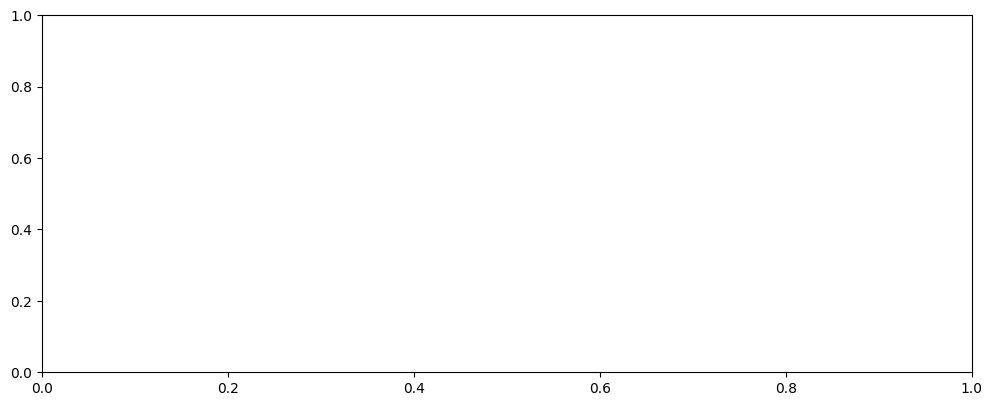

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import mplfinance as mpf
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

class StockPlotterMPL:
    def __init__(self, ticker, start_date, end_date):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.data = None

    def get_data(self):
        # Download data
        data = yf.download(tickers = self.ticker, start = self.start_date, end = self.end_date)
        for i in ["Open", "High", "Close", "Low"]: 
            data[i] = data[i][f"{self.ticker}"].astype("float64")
        self.data = data
        return data

    def calculate_technical_indicators(self):
        # Calculate EMA
        self.data['EMA_8'] = self.data['Close'].ewm(span=8, adjust=False).mean()
        self.data['EMA_21'] = self.data['Close'].ewm(span=21, adjust=False).mean()

        # Calculate SMA
        self.data['SMA_10'] = self.data['Close'].rolling(window=10).mean()

        # Calculate RSI
        delta = self.data['Close'].diff()
        gain = delta.where(delta > 0, 0).rolling(window=14).mean()
        loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
        rs = gain / loss
        self.data['RSI_14'] = 100 - (100 / (1 + rs))

        # Calculate MACD
        ema_12 = self.data['Close'].ewm(span=12, adjust=False).mean()
        ema_26 = self.data['Close'].ewm(span=26, adjust=False).mean()
        self.data['MACD'] = ema_12 - ema_26
        self.data['MACD_Signal'] = self.data['MACD'].ewm(span=9, adjust=False).mean()

        return self.data

    def plot_with_indicators(self):
        # Create figure and grid
        fig = plt.figure(figsize=(12, 8))
        gs = GridSpec(2, 1, height_ratios=[2, 1], hspace=0.3)

        # Plot candlesticks
        ax1 = fig.add_subplot(gs[0])
        mpf.plot(self.data, type='candle')  #, style='charles', ax=ax1, volume=False)

        # Add technical indicators to price subplot
        ax1.plot(self.data.index, self.data['EMA_8'], label='EMA 8', color='orange', linewidth=1)
        ax1.plot(self.data.index, self.data['EMA_21'], label='EMA 21', color='blue', linewidth=1)
        ax1.plot(self.data.index, self.data['SMA_10'], label='SMA 10', color='purple', linewidth=1)
        ax1.set_ylabel('Price (USD)')
        ax1.set_title(f'{self.ticker} Stock Price')
        ax1.legend(loc='upper left')
        ax1.grid(True, linestyle='--', alpha=0.7)

        # Plot indicators
        ax2 = fig.add_subplot(gs[1], sharex=ax1)
        ax2.plot(self.data.index, self.data['RSI_14'], label='RSI 14', color='gray', linewidth=1)
        ax2.plot(self.data.index, self.data['MACD'], label='MACD', color='blue', linewidth=1)
        ax2.plot(self.data.index, self.data['MACD_Signal'], label='MACD Signal', color='orange', linewidth=1)
        ax2.axhline(y=0, color='black', linestyle='--', alpha=0.3)
        ax2.set_ylabel('Indicators')
        ax2.legend(loc='upper left')
        ax2.grid(True, linestyle='--', alpha=0.7)

        plt.show()

if __name__ == "__main__":
    start_date = '2022-01-01'
    end_date = '2022-12-30'

    plotter = StockPlotterMPL(ticker='AAPL', start_date=start_date, end_date=end_date)
    plotter.get_data()
    plotter.calculate_technical_indicators()
    plotter.plot_with_indicators()

[*********************100%***********************]  1 of 1 completed

1m


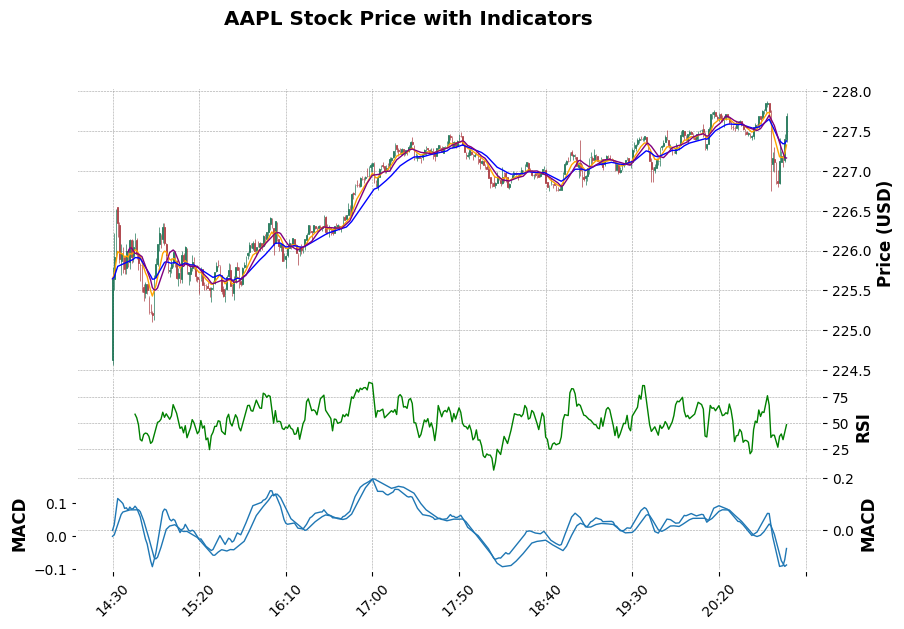

In [43]:
import yfinance as yf
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from IPython.display import display

class StockPlotterMPL:
    def __init__(self, ticker, start_date, end_date, interval):
        self.ticker = ticker.upper()
        self.start_date = start_date
        self.end_date = end_date
        self.interval = interval
        self.data = None

    def get_data(self):
        # Download data
        data = yf.download(tickers=self.ticker, start=self.start_date, end=self.end_date, interval = self.interval)

        # print(data["Open"][f"{self.ticker}"])
        
        if data.empty:
            raise ValueError(f"No data found for ticker {self.ticker}")

        # Ensure index is datetime
        data.index = pd.to_datetime(data.index)

        # Keep only OHLCV columns
        ohlc_columns = ['Open', "High", 'Low', 'Close', 'Volume']
        
        for i in ohlc_columns: 
            data[i] = data[i][f"{self.ticker}"]

        # Drop rows with missing values
        data.dropna(inplace=True)

        # Convert to float
        data = data.astype(float)

        self.data = data
        return data

    def calculate_technical_indicators(self):
        # Calculate EMA
        self.data['EMA_8'] = self.data['Close'].ewm(span=8, adjust=False).mean()
        self.data['EMA_21'] = self.data['Close'].ewm(span=21, adjust=False).mean()

        # Calculate SMA
        self.data['SMA_10'] = self.data['Close'].rolling(window=10).mean()

        # Calculate RSI
        delta = self.data['Close'].diff()
        gain = delta.where(delta > 0, 0.0)
        loss = -delta.where(delta < 0, 0.0)
        avg_gain = gain.rolling(window=14).mean()
        avg_loss = loss.rolling(window=14).mean()
        rs = avg_gain / avg_loss
        self.data['RSI_14'] = 100 - (100 / (1 + rs))

        # Calculate MACD
        ema_12 = self.data['Close'].ewm(span=12, adjust=False).mean()
        ema_26 = self.data['Close'].ewm(span=26, adjust=False).mean()
        self.data['MACD'] = ema_12 - ema_26
        self.data['MACD_Signal'] = self.data['MACD'].ewm(span=9, adjust=False).mean()

        return self.data

    def plot_with_indicators(self):
        # Prepare additional plots for the indicators
        add_plots = [
            mpf.make_addplot(self.data['EMA_8'], color='orange', width=1),
            mpf.make_addplot(self.data['EMA_21'], color='blue', width=1),
            mpf.make_addplot(self.data['SMA_10'], color='purple', width=1),
        ]

        # Add RSI to a new panel
        add_plots.append(mpf.make_addplot(self.data['RSI_14'], panel=1, color='green', width=1, ylabel='RSI'))

        # Add MACD and MACD Signal to another panel
        macd_df = pd.DataFrame({
            'MACD': self.data['MACD'],
            'MACD_Signal': self.data['MACD_Signal']
        }, index=self.data.index)
        add_plots.append(mpf.make_addplot(macd_df, panel=2, width=1, ylabel='MACD'))

        data = {"Open": self.data["Open"][f"{self.ticker}"], 
                "Close": self.data["Close"][f"{self.ticker}"], 
                "High": self.data["High"][f"{self.ticker}"], 
                "Low": self.data["Low"][f"{self.ticker}"], 
                "Volume": self.data["Volume"][f"{self.ticker}"]}
        
        df = pd.DataFrame(data)
        
        # Plot with mplfinance
        mpf.plot(
            df,
            type='candle',
            style='charles',
            addplot=add_plots,
            volume=False,
            title=f'{self.ticker} Stock Price with Indicators',
            ylabel='Price (USD)',
            panel_ratios=(3, 1, 1),
            figratio=(12, 8),
            figscale=1.2,
        )

if __name__ == "__main__":
    start_date = '2024-11-07'
    end_date = '2024-11-08'

    plotter = StockPlotterMPL(ticker='AAPL', start_date=start_date, end_date=end_date, interval = "1m")
    print(plotter.interval)
    plotter.get_data()
    plotter.calculate_technical_indicators()
    # display(plotter.data)
    plotter.plot_with_indicators()

In [49]:
import yfinance as yf
import pandas as pd
import plotly.graph_objects as go
import plotly.subplots as sp
from plotly.offline import iplot


class StockPlotter:
    def __init__(self, ticker, start_date, end_date, interval):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.interval = interval
        self.data = None

    def get_data(self):
        # Retrieve stock data from Yahoo Finance
        data = yf.download(tickers = self.ticker, start = self.start_date, end = self.end_date, interval = self.interval)
        data = data.reset_index() 
        for i in ["Open", "High", "Close", "Low"]: 
            data[i] = data[i].astype("float64")
        self.data = data
        return data
    
    def calculate_technical_indicators(self):
    # Calculate EMA
        self.data['EMA_8'] = self.data['Close'][f"{self.ticker}"].ewm(span=8, adjust=False).mean()
        self.data['EMA_21'] = self.data['Close'][f"{self.ticker}"].ewm(span=21, adjust=False).mean()

        # Calculate SMA
        self.data['SMA_10'] = self.data['Close'][f"{self.ticker}"].rolling(window=10).mean()

        # Calculate RSI
        delta = self.data['Close'][f"{self.ticker}"].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        self.data['RSI_14'] = 100 - (100 / (1 + rs))

        # Calculate MACD
        ema_12 = self.data['Close'][f"{self.ticker}"].ewm(span=12, adjust=False).mean()
        ema_26 = self.data['Close'][f"{self.ticker}"].ewm(span=26, adjust=False).mean()
        self.data['MACD'] = ema_12 - ema_26
        self.data['MACD_Signal'] = self.data['MACD'].ewm(span=9, adjust=False).mean()

        # Calculate Parabolic SAR
        self.data['SAR'] = self.data['Close'][f"{self.ticker}"].rolling(window=4).apply(lambda x: x.min() if x.idxmin() == x.index[-1] else x.max())

        return self.data
        
    def plot_with_indicators_2(self):
    # Create figure with secondary y-axis using subplots
        fig = sp.make_subplots(rows=2, cols=1, 
                            shared_xaxes=True,
                            vertical_spacing=0.03,
                            subplot_titles=('Price', 'Indicators'),
                            row_heights=[0.7, 0.3])

        # Add candlestick with enhanced visibility settings
        fig.add_trace(go.Candlestick(
            x=self.data["Datetime"],
            open=self.data['Open'][f"{self.ticker}"],
            high=self.data['High'][f"{self.ticker}"],
            low=self.data['Low'][f"{self.ticker}"],
            close=self.data['Close'][f"{self.ticker}"],
            name='Candlestick',
            increasing_line_color='#26a69a',
            decreasing_line_color='#ef5350',
            increasing_fillcolor='#26a69a',
            decreasing_fillcolor='#ef5350',
            line=dict(width=1),
            opacity=1,
            showlegend=True,
            visible=True,
        ), row=1, col=1)

        # Add EMA lines to first subplot
        fig.add_trace(go.Scatter(
            x=self.data.index, y=self.data['EMA_8'],
            mode='lines', name='EMA 8',
            line=dict(color='orange', width=1)
        ), row=1, col=1)
        
        fig.add_trace(go.Scatter(
            x=self.data.index, y=self.data['EMA_21'],
            mode='lines', name='EMA 21',
            line=dict(color='blue', width=1)
        ), row=1, col=1)

        # Add SMA to first subplot
        fig.add_trace(go.Scatter(
            x=self.data.index, y=self.data['SMA_10'],
            mode='lines', name='SMA 10',
            line=dict(color='purple', width=1)
        ), row=1, col=1)

        # Add indicators to second subplot
        fig.add_trace(go.Scatter(
            x=self.data.index, y=self.data['RSI_14'],
            mode='lines', name='RSI 14',
            line=dict(color='gray', width=1)
        ), row=2, col=1)

        fig.add_trace(go.Scatter(
            x=self.data.index, y=self.data['MACD'],
            mode='lines', name='MACD',
            line=dict(color='blue', width=1)
        ), row=2, col=1)

        fig.add_trace(go.Scatter(
            x=self.data.index, y=self.data['MACD_Signal'],
            mode='lines', name='MACD Signal',
            line=dict(color='orange', width=1)
        ), row=2, col=1)

        fig.update_layout(
            title='Stock Price Data with Technical Indicators',
            height=800,
            showlegend=True,
            xaxis_rangeslider_visible=False,
            legend=dict(
                yanchor="top",
                y=0.99,
                xanchor="left",
                x=0.01,
                bgcolor='rgba(255, 255, 255, 0.8)',
                bordercolor='rgba(0, 0, 0, 0.2)',
                borderwidth=1
            ),
            # Ensure candlestick visibility
            uirevision=True
        )

        # Update yaxis properties
        fig.update_yaxes(title_text="Price", row=1, col=1)
        fig.update_yaxes(title_text="Indicators", row=2, col=1)

        fig.show()
        
    def plot_with_indicators_3(self):
        # Convert dataframes to series 
        # Create figure
        fig_2 = go.Figure(data=[go.Candlestick(
            x=self.data["Datetime"],
            open=self.data['Open']["AAPL"],
            high=self.data['High']["AAPL"],
            low=self.data['Low']["AAPL"],
            close=self.data['Close']["AAPL"])])

        # print(type(self.data))
        # print(type(self.data["Datetime"]))
        # print(type(self.data["Open"][f"{self.ticker}"]))
        
        fig_2.show()
        
start_date = '2024-11-01'
end_date = '2024-11-08'        

example = StockPlotter(ticker = 'AAPL', start_date = start_date, end_date = end_date, interval = "15m") 

example.get_data() 
# print(example.data)
example.calculate_technical_indicators() 
example.plot_with_indicators_2()
example.plot_with_indicators_3()

[*********************100%***********************]  1 of 1 completed


In [55]:
import yfinance as yf
import pandas as pd
import plotly.graph_objects as go
import plotly.subplots as sp
import pandas_market_calendars as mcal

class StockPlotter:
    def __init__(self, ticker, start_date, end_date, interval):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.interval = interval
        self.data = None

    def get_data(self):
        # Retrieve stock data from Yahoo Finance
        data = yf.download(
            tickers=self.ticker,
            start=self.start_date,
            end=self.end_date,
            interval=self.interval,
            threads=False
        )
        data = data.reset_index()
        for col in ["Open", "High", "Close", "Low"]:
            data[col] = data[col].astype("float64")

        # Exclude weekends
        data = data[data['Datetime'].dt.weekday < 5]

        # Exclude US Stock Market Holidays
        nyse = mcal.get_calendar('NYSE')
        market_holidays = nyse.holidays().holidays
        data = data[~data['Datetime'].dt.normalize().isin(market_holidays)]

        self.data = data
        return data

    def calculate_technical_indicators(self):
        # Calculate EMA
        self.data['EMA_8'] = self.data['Close'][f"{self.ticker}"].ewm(span=8, adjust=False).mean()
        self.data['EMA_21'] = self.data['Close'][f"{self.ticker}"].ewm(span=21, adjust=False).mean()

        # Calculate SMA
        self.data['SMA_10'] = self.data['Close'][f"{self.ticker}"].rolling(window=10).mean()

        # Calculate RSI
        delta = self.data['Close'][f"{self.ticker}"].diff()
        gain = delta.clip(lower=0).rolling(window=14).mean()
        loss = -delta.clip(upper=0).rolling(window=14).mean()
        rs = gain / loss
        self.data['RSI_14'] = 100 - (100 / (1 + rs))

        # Calculate MACD
        ema_12 = self.data['Close'][f"{self.ticker}"].ewm(span=12, adjust=False).mean()
        ema_26 = self.data['Close'][f"{self.ticker}"].ewm(span=26, adjust=False).mean()
        self.data['MACD'] = ema_12 - ema_26
        self.data['MACD_Signal'] = self.data['MACD'].ewm(span=9, adjust=False).mean()

        return self.data

    def plot_with_indicators_2(self):
        # Create figure with subplots
        fig = sp.make_subplots(
            rows=2, cols=1, shared_xaxes=True,
            vertical_spacing=0.03,
            subplot_titles=('Price', 'Indicators'),
            row_heights=[0.7, 0.3]
        )

        # Add candlestick chart
        fig.add_trace(go.Candlestick(
            x=self.data["Datetime"],
            open=self.data['Open'][f"{self.ticker}"],
            high=self.data['High'][f"{self.ticker}"],
            low=self.data['Low'][f"{self.ticker}"],
            close=self.data['Close'][f"{self.ticker}"],
            name='Candlestick',
            increasing_line_color='#26a69a',
            decreasing_line_color='#ef5350',
            showlegend=True
        ), row=1, col=1)

        # Add EMA lines
        fig.add_trace(go.Scatter(
            x=self.data["Datetime"], y=self.data['EMA_8'],
            mode='lines', name='EMA 8',
            line=dict(color='orange', width=1)
        ), row=1, col=1)

        fig.add_trace(go.Scatter(
            x=self.data["Datetime"], y=self.data['EMA_21'],
            mode='lines', name='EMA 21',
            line=dict(color='blue', width=1)
        ), row=1, col=1)

        # Add SMA line
        fig.add_trace(go.Scatter(
            x=self.data["Datetime"], y=self.data['SMA_10'],
            mode='lines', name='SMA 10',
            line=dict(color='purple', width=1)
        ), row=1, col=1)

        # Add RSI indicator
        fig.add_trace(go.Scatter(
            x=self.data["Datetime"], y=self.data['RSI_14'],
            mode='lines', name='RSI 14',
            line=dict(color='gray', width=1)
        ), row=2, col=1)

        # Add MACD indicators
        fig.add_trace(go.Scatter(
            x=self.data["Datetime"], y=self.data['MACD'],
            mode='lines', name='MACD',
            line=dict(color='blue', width=1)
        ), row=2, col=1)

        fig.add_trace(go.Scatter(
            x=self.data["Datetime"], y=self.data['MACD_Signal'],
            mode='lines', name='MACD Signal',
            line=dict(color='orange', width=1)
        ), row=2, col=1)

        # Update layout
        fig.update_layout(
            title='Stock Price Data with Technical Indicators',
            height=800,
            showlegend=True,
            xaxis_rangeslider_visible=False,
            legend=dict(
                yanchor="top",
                y=0.99,
                xanchor="left",
                x=0.01,
                bgcolor='rgba(255, 255, 255, 0.8)',
                bordercolor='rgba(0, 0, 0, 0.2)',
                borderwidth=1
            )
        )

        # Update y-axis labels
        fig.update_yaxes(title_text="Price", row=1, col=1)
        fig.update_yaxes(title_text="Indicators", row=2, col=1)

        fig.show()

    def plot_with_indicators_3(self):
        # Create candlestick figure
        fig_2 = go.Figure(data=[go.Candlestick(
            x=self.data["Datetime"],
            open=self.data['Open'][f"{self.ticker}"],
            high=self.data['High'][f"{self.ticker}"],
            low=self.data['Low'][f"{self.ticker}"],
            close=self.data['Close'][f"{self.ticker}"]
        )])

        fig_2.show()

# Specify your date range
start_date = '2024-10-01'
end_date = '2024-11-08'

example = StockPlotter(
    ticker='AAPL',
    start_date=start_date,
    end_date=end_date,
    interval='1h'
)

example.get_data()
example.calculate_technical_indicators()
example.plot_with_indicators_2()
example.plot_with_indicators_3()

[*********************100%***********************]  1 of 1 completed


In [75]:
import yfinance as yf
import pandas as pd
import plotly.graph_objects as go
import plotly.subplots as sp
import pandas_market_calendars as mcal

class StockPlotter:
    def __init__(self, ticker, start_date, end_date, interval):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.interval = interval
        self.data = None

    def get_data(self):
        # Retrieve stock data from Yahoo Finance
        data = yf.download(
            tickers=self.ticker,
            start=self.start_date,
            end=self.end_date,
            interval=self.interval,
            threads=False
        )
        data = data.reset_index()
        for col in ["Open", "High", "Close", "Low"]:
            data[col] = data[col].astype("float64")

        # Convert 'Datetime' to Eastern Time
        data['Datetime'] = data['Datetime'].dt.tz_convert('US/Eastern')

        # Exclude times outside trading hours (9:30 AM to 4:00 PM Eastern Time)
        data = data[
            (data['Datetime'].dt.time >= pd.to_datetime('09:30:00').time()) &
            (data['Datetime'].dt.time <= pd.to_datetime('16:00:00').time())
        ]

        # Exclude weekends
        data = data[data['Datetime'].dt.weekday < 5]

        # Exclude US Stock Market Holidays
        nyse = mcal.get_calendar('NYSE')
        market_holidays = nyse.holidays().holidays
        data = data[~data['Datetime'].dt.normalize().isin(market_holidays)]

        self.data = data
        return data

    def calculate_technical_indicators(self):
        # Calculate EMA
        self.data['EMA_8'] = self.data['Close'][f"{self.ticker}"].ewm(span=8, adjust=False).mean()
        self.data['EMA_21'] = self.data['Close'][f"{self.ticker}"].ewm(span=21, adjust=False).mean()

        # Calculate SMA
        self.data['SMA_10'] = self.data['Close'][f"{self.ticker}"].rolling(window=10).mean()

        # Calculate RSI
        delta = self.data['Close'][f"{self.ticker}"].diff()
        gain = delta.clip(lower=0).rolling(window=14).mean()
        loss = -delta.clip(upper=0).rolling(window=14).mean()
        rs = gain / loss
        self.data['RSI_14'] = 100 - (100 / (1 + rs))

        # Calculate MACD
        ema_12 = self.data['Close'][f"{self.ticker}"].ewm(span=12, adjust=False).mean()
        ema_26 = self.data['Close'][f"{self.ticker}"].ewm(span=26, adjust=False).mean()
        self.data['MACD'] = ema_12 - ema_26
        self.data['MACD_Signal'] = self.data['MACD'].ewm(span=9, adjust=False).mean()

        return self.data

    def plot_with_indicators_2(self):
        # Create figure with subplots
        fig = sp.make_subplots(
            rows=3, cols=1, shared_xaxes=True,
            vertical_spacing=0.03,
            subplot_titles=(f"{self.ticker} Price", "", ""),
            row_heights=[0.6, 0.2, 0.2]
        )

        # Add candlestick chart
        fig.add_trace(go.Candlestick(
            x=self.data["Datetime"],
            open=self.data['Open'][f"{self.ticker}"],
            high=self.data['High'][f"{self.ticker}"],
            low=self.data['Low'][f"{self.ticker}"],
            close=self.data['Close'][f"{self.ticker}"],
            name='Candlestick',
            increasing_line_color='#26a69a',
            decreasing_line_color='#ef5350',
            showlegend=True
        ), row=1, col=1)

        # Add EMA lines
        fig.add_trace(go.Scatter(
            x=self.data["Datetime"], y=self.data['EMA_8'],
            mode='lines', name='EMA 8',
            line=dict(color='orange', width=1)
        ), row=1, col=1)

        fig.add_trace(go.Scatter(
            x=self.data["Datetime"], y=self.data['EMA_21'],
            mode='lines', name='EMA 21',
            line=dict(color='blue', width=1)
        ), row=1, col=1)

        # Add SMA line
        fig.add_trace(go.Scatter(
            x=self.data["Datetime"], y=self.data['SMA_10'],
            mode='lines', name='SMA 10',
            line=dict(color='purple', width=1)
        ), row=1, col=1)

        # Add RSI indicator
        fig.add_trace(go.Scatter(
            x=self.data["Datetime"], y=self.data['RSI_14'],
            mode='lines', name='RSI 14',
            line=dict(color='gray', width=1)
        ), row=2, col=1)

        # Add MACD indicators
        fig.add_trace(go.Scatter(
            x=self.data["Datetime"], y=self.data['MACD'],
            mode='lines', name='MACD',
            line=dict(color='blue', width=1)
        ), row=3, col=1)

        fig.add_trace(go.Scatter(
            x=self.data["Datetime"], y=self.data['MACD_Signal'],
            mode='lines', name='MACD Signal',
            line=dict(color='orange', width=1)
        ), row=3, col=1)

        # Update layout
        fig.update_layout(
            title='Stock Price Data with Technical Indicators',
            height=800,
            showlegend=True,
            xaxis_rangeslider_visible=False,
            legend=dict(
                yanchor="top",
                y=0.99,
                xanchor="left",
                x=0.01,
                bgcolor='rgba(255, 255, 255, 0.8)',
                bordercolor='rgba(0, 0, 0, 0.2)',
                borderwidth=1
            )
        )

        # Remove gaps for non-trading hours
        nyse = mcal.get_calendar('NYSE')
        market_holidays = nyse.holidays().holidays

        fig.update_xaxes(
            rangebreaks=[
                dict(bounds=["sat", "mon"]),
                dict(bounds=[16, 9.5], pattern="hour"),
                dict(values=market_holidays)
            ]
        )

        # Update y-axis labels
        fig.update_yaxes(title_text="USD", row=1, col=1)
        fig.update_yaxes(title_text="RSI 14", row=2, col=1)
        fig.update_yaxes(title_text="MACD/MACD Signal", row=3, col=1)
        
        fig.add_hline(y = 30, row = 2, col = 1, line_dash = "dash", line_color = "red", opacity = 0.5)
        fig.add_hline(y = 70, row = 2, col = 1, line_dash = "dash", line_color = "green", opacity = 0.5)

        fig.show()

    def plot_with_indicators_3(self):
        # Create candlestick figure
        fig_2 = go.Figure(data=[go.Candlestick(
            x=self.data["Datetime"],
            open=self.data['Open'][f"{self.ticker}"],
            high=self.data['High'][f"{self.ticker}"],
            low=self.data['Low'][f"{self.ticker}"],
            close=self.data['Close'][f"{self.ticker}"]
        )])

        # Remove gaps for non-trading hours
        nyse = mcal.get_calendar('NYSE')
        market_holidays = nyse.holidays().holidays

        fig_2.update_xaxes(
            rangebreaks=[
                dict(bounds=["sat", "mon"]),
                dict(bounds=[16, 9.5], pattern="hour"),
                dict(values=market_holidays)
            ]
        )

        fig_2.show()

# Specify your date range
start_date = '2024-10-01'
end_date = '2024-11-08'

example = StockPlotter(
    ticker='NVDA',
    start_date=start_date,
    end_date=end_date,
    interval='1h'
)

example.get_data()
example.calculate_technical_indicators()
example.plot_with_indicators_2()
example.plot_with_indicators_3()

[*********************100%***********************]  1 of 1 completed
